In [1]:
# Import Packages
import logging

from matplotlib import pyplot as plt
import pandas as pd
import os

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
from azureml.core.dataset import Dataset
from azureml.train.automl import AutoMLConfig
from azureml.train.automl.run import AutoMLRun
from azureml.core.compute import ComputeTarget
from azureml.core import Datastore

from sklearn.metrics import confusion_matrix
import numpy as np
import itertools

In [2]:
# Connect to workspace
ws = Workspace.from_config()

# Choose a name for experiment
experiment_name = 'credit-card-default-automl'

# Create experiment
experiment = Experiment(ws, experiment_name)

In [3]:
# Import data into dataframe
dataset = Dataset.get_by_name(ws, name='default_credit_card_data')
train_dataset, test_dataset = dataset.random_split(percentage=0.3, seed=123)
df = dataset.to_pandas_dataframe()
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [4]:
# Upload training and test data to blob store
local_path = 'data/credit_default_training_data.csv'
df = train_dataset.to_pandas_dataframe()
df.to_csv(local_path)

local_path = 'data/credit_default_test_data.csv'
df = test_dataset.to_pandas_dataframe()
df.to_csv(local_path)

# get the datastore to upload prepared data
datastore = Datastore(ws, 'blobstorage')

# upload the local file from src_dir to the target_path in datastore
datastore.upload(src_dir='data', target_path='processed')

Uploading an estimated of 3 files
Uploading data/credit_default_test_data.csv
Uploading data/credit_default_training_data.csv
Uploading data/training_data.csv
Uploaded data/credit_default_training_data.csv, 1 files out of an estimated total of 3
Uploaded data/training_data.csv, 2 files out of an estimated total of 3
Uploaded data/credit_default_test_data.csv, 3 files out of an estimated total of 3
Uploaded 3 files


$AZUREML_DATAREFERENCE_0f56250198df484589356a101cfc3a5c

In [5]:
# create a dataset referencing the cloud location
dataset = Dataset.Tabular.from_delimited_files(datastore.path('processed/credit_default_training_data.csv'))
dataset = dataset.register(workspace=ws,
                                 name='credit_default_training_data',
                                 description='training data for credit card default model')

In [6]:
# create a dataset referencing the cloud location
dataset = Dataset.Tabular.from_delimited_files(datastore.path('processed/credit_default_test_data.csv'))
dataset = dataset.register(workspace=ws,
                                 name='credit_default_test_data',
                                 description='test data for credit card default model')

In [7]:
# Identify compute target for training
cluster_name = 'aml-demo-tc'
compute_target = ComputeTarget(workspace=ws, name=cluster_name)

In [9]:
# Configure automl experiment
automl_settings = {
    "n_cross_validations": 3,
    "primary_metric": 'AUC_weighted',
    "enable_early_stopping": True,
    "max_concurrent_iterations": 2,
    "experiment_timeout_hours": 0.5,
    "verbosity": logging.INFO,
}

label_column_name = 'default payment next month'
automl_config = AutoMLConfig(task = 'classification',
                             debug_log = 'automl_errors.log',
                             compute_target = compute_target,
                             training_data = train_dataset,
                             label_column_name = label_column_name,
                             **automl_settings
                            )

In [ ]:
# Submit experiment
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote compute: aml-demo-tc
Parent Run ID: AutoML_f73e1768-455e-4a83-9fdd-1f05f1ea12e8

Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         1   MaxAbsScaler XGBoostClassifier                 0:02:45       0.7731    0.7731
         0   MaxAbsScaler LightGBM 

In [ ]:
# Return best run and model for that run
best_run, fitted_model = remote_run.get_output()

In [14]:
# # Grab automl run
# experiment_name = 'credit-card-default-automl'
# run_id ='AutoML_f73e1768-455e-4a83-9fdd-1f05f1ea12e8'
# experiment = Experiment(ws, experiment_name)
# remote_run = AutoMLRun(experiment = experiment, run_id = run_id)
# best_run, fitted_model = remote_run.get_output()

In [15]:
# Convert the test data to dataframe
X_test_df = test_dataset.drop_columns(columns=[label_column_name]).to_pandas_dataframe()
Y_test_df = test_dataset.keep_columns(columns=[label_column_name], validate=True).to_pandas_dataframe()

In [16]:
# Predict on test data
Y_pred = fitted_model.predict(X_test_df)

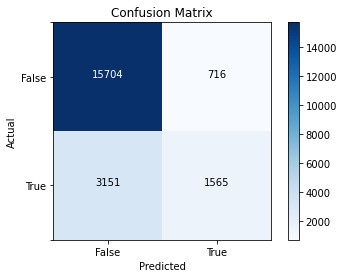

In [17]:
# Plot confusion matrix to evaluate model
cf =confusion_matrix(Y_test_df.values,Y_pred)
plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
plt.colorbar()
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
class_labels = ['False','True']
tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks,class_labels)
plt.yticks([-0.5,0,1,1.5],['','False','True',''])
# plotting text value inside cells
thresh = cf.max() / 2.
for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
    plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
plt.show()